In [1]:
from matplotlib.pyplot import *
from matplotlib import pyplot
import math
from scipy.optimize import *
import numpy
import os
import datetime
from scipy.io import loadmat

In [2]:
file_dir = "./data/"
C_limit1 = -0.1
C_limit2 = 1.1
eye_left = -800
eye_right = 500
S_eye_left = -100
S_eye_right = 900
speed_TH = 40

In [3]:
currentDT = datetime.datetime.now()
SavePath = "./results/" + currentDT.strftime("%Y_%m_%d_%H_%M_%S") + "/"
os.mkdir(SavePath)

In [4]:
S_index = -1
StaticSections = []
DynamicSections = []
DY_delaySections = []
GA_delaySections = []
DY_EYSections = []
GA_EYSections = []
MatDatas = []

In [5]:
class Section:
    
    def __init__(self,mode):
        self.sub_index = 0
        self.mode = mode
        self.AZ_RW_dir = []
        self.delay_RW = []
        self.move_target = []
        self.AZ_percent = {}
        self.delay_percent = {}
        self.eye_samples = []
        
    def cal_AC(self):
        AZ_RI_TO = {}
        for ARD in self.AZ_RW_dir:
            if(ARD[0] in AZ_RI_TO):
                AZ_RI_TO[ARD[0]][1] += 1
            else:
                AZ_RI_TO[ARD[0]] = [0,1]
            if(ARD[1] == 1):
                AZ_RI_TO[ARD[0]][0] += 1
        for ART in AZ_RI_TO.keys():
            self.AZ_percent[ART] = float(AZ_RI_TO[ART][0]) / float(AZ_RI_TO[ART][1])
    
    def cal_delay(self):
        DE_RI_TO = {}
        for DR in self.delay_RW:
            if(DR[0] in DE_RI_TO):
                DE_RI_TO[DR[0]][1] += 1
            else:
                DE_RI_TO[DR[0]] = [0,1]
            if(DR[1] == 1):
                DE_RI_TO[DR[0]][0] += 1
        for DRT in DE_RI_TO.keys():
            self.delay_percent[DRT] = float(DE_RI_TO[DRT][0]) / float(DE_RI_TO[DRT][1])

In [6]:
class MatData:
    
    def __init__(self):
        self.init_sample = 0
        self.SA_HS_LES_RES = []
        self.skip_index = []
        self.gaze_speed = []
        self.eye_index = 0
        
    def gaze_cal(self):
        self.gaze_speed = self.SA_HS_LES_RES[:,self.eye_index + 2] + self.SA_HS_LES_RES[:,1]

In [7]:
def read_file(AF_name, DF_name,sectionN = 0):
    try:
        file = open(file_dir+AF_name,"r")
        lines = file.readlines()
    except:
        lines = []
    
    section = Section("")
    
    start_flag = False
    S_index = 0
    last_delay = 0.0
    sample = 0
    for line in lines:
        strings = line.split()
        if(len(strings)<1):
            continue
        if(strings[1] == "start"):
            if(S_index == sectionN):
                start_flag = True
                section.mode = strings[4]
            else:
                start_flag = False
            S_index += 1
        if(start_flag):
            try:
                AZ = int(strings[3])
            except:
                AZ = -100
            if(AZ >= 0):
                RW = 1 if (strings[4] == "True") else 0
                section.AZ_RW_dir.append((AZ,RW,strings[5]))
                section.delay_RW.append((last_delay,RW))
            if(AZ == -2):
                try:
                    last_delay = float(strings[4])
                except:
                    last_delay = -1.0
                try:
                    sample = int(strings[1])
                except:
                    sample = -1
                section.eye_samples.append(sample)
    file.close()
    
    try:
        file = open(file_dir+DF_name,"r")
        lines = file.readlines()
    except:
        lines = []
    
    for line in lines:
        strings = line.split()
        if(len(strings)<1):
            continue
        if(strings[4] == "MoveTarget"):
            try:
                simS = int(strings[2])
                degree = float(strings[5]) if (strings[6] == "1") else -(float(strings[5]))
            except:
                simS = int(-1)
                degree = 0.0
            section.move_target.append((simS,degree))
            
            
    return section

In [8]:
def read_mat(filename):
    MD = MatData()
    file = loadmat(file_dir+filename)
    MD.init_sample = file['sampleNo'][0]
    MD.SA_HS_LES_RES = numpy.column_stack((file['sampleNo'],file['head'][0][0][1][:,2],file['leftEye'][0][0][1][:,2],file['rightEye'][0][0][1][:,2]))
    return MD

In [9]:
def plotplot(x_data,y_data,legends,limit1,limit2):
    ylim(limit1, limit2)
    tpl, = plot(x_data,y_data,label = legends)
    return tpl

In [10]:
def plot_ac(section,lab_mode = 0):
    x_data = sorted(section.AZ_percent.keys())
    y_data = []
    for x in x_data:
        y_data.append(section.AZ_percent[x])
    if(lab_mode == 0):
        tpl = plotplot(x_data,y_data,section.mode,C_limit1,C_limit2)
    elif(lab_mode == 1):
        tpl = plotplot(x_data,y_data,section.sub_index,C_limit1,C_limit2)
    return tpl

In [11]:
def plot_ST_DY(section1,section2):
    pyplot.rcParams["figure.figsize"] = (20,10)
    tpl1 = plot_ac(section1)
    tpl2 = plot_ac(section2)
    pyplot.legend(handles=[tpl1, tpl2])
    pyplot.savefig(SavePath+"AcuityResult_S"+str(S_index)+".png")
    pyplot.show()

In [12]:
def plot_delay(section,lab_mode = 0):
    x_data = sorted(section.delay_percent.keys())
    y_data = []
    for x in x_data:
        y_data.append(section.delay_percent[x])
    if(lab_mode == 0):
        tpl = plotplot(x_data,y_data,section.mode,C_limit1,C_limit2)
    elif(lab_mode == 1):
        tpl = plotplot(x_data,y_data,section.sub_index,C_limit1,C_limit2)
    return tpl

In [13]:
def plot_DYD_GAD(section1,section2):
    section2.mode = "GazeShift"
    pyplot.rcParams["figure.figsize"] = (20,10)
    tpl1 = plot_delay(section1)
    tpl2 = plot_delay(section2)
    pyplot.legend(handles=[tpl1, tpl2])
    pyplot.savefig(SavePath+"DelayResult_"+str(S_index)+".png")
    pyplot.show()

In [19]:
def plot_eye_single(index, mat_data):
    labels = ["HeadSpeed","EyeSpeed","GazeSpeed"]
    x_data = range(0,S_eye_right-S_eye_left)
    y_data = []
    tpls = []
    start = int(index + eye_left)
    end = int(index + eye_right)
    T_index = -1
    for i in range(start,end):
        if(abs(mat_data.SA_HS_LES_RES[i,1]) > speed_TH):
            T_index = i
            break
    T_start = T_index + S_eye_left
    T_end = T_index + S_eye_right
    
    y_data = mat_data.SA_HS_LES_RES[int(T_start):int(T_end),1]
    tpl, = plot(x_data,y_data,label = labels[0])
    tpls.append(tpl)
    
    y_data = mat_data.SA_HS_LES_RES[int(T_start):int(T_end),mat_data.eye_index + 2]
    tpl, = plot(x_data,y_data,label = labels[1])
    tpls.append(tpl)
    
    y_data = mat_data.gaze_speed[int(T_start):int(T_end)]
    tpl, = plot(x_data,y_data,label = labels[2])
    tpls.append(tpl)
    return tpls

In [15]:
def plot_eye(section,mat_data,lab_mode = 0):
    for sample in section.eye_samples:
        tpl = plot_eye_single(sample - mat_data.init_sample,mat_data)
        pyplot.legend(handles = tpl)
        pyplot.show()
    return tpl

In [16]:
def run_subject(AC_log1,AC_log2,JU_log1,JU_log2,JU_log3,EY_log,EY_JU_log,Mat_log,eye_index):
    section1 = read_file(AC_log1,JU_log1,sectionN = 0)
    section2 = read_file(AC_log1,JU_log1,sectionN = 1)
    section3 = read_file(AC_log2,JU_log2,sectionN = 0)
    section4 = read_file(AC_log2,JU_log3,sectionN = 1)
    section5 = read_file(EY_log,EY_JU_log,sectionN = 0)
    section6 = read_file(EY_log,EY_JU_log,sectionN = 1)
    section1.sub_index = S_index
    section2.sub_index = S_index
    section3.sub_index = S_index
    section4.sub_index = S_index
    section5.sub_index = S_index
    section6.sub_index = S_index
    mat_data = read_mat(Mat_log)
    mat_data.eye_index = eye_index
    
    section1.cal_AC()
    section2.cal_AC()
    section3.cal_delay()
    section4.cal_delay()
    section5.mode = "DynamicEye"
    section6.mode = "GazeShiftEye"
    mat_data.gaze_cal()
    
    plot_ST_DY(section1,section2)
    plot_DYD_GAD(section3,section4)
    plot_eye(section5,mat_data)
    plot_eye(section6,mat_data)
    
    StaticSections.append(section1)
    DynamicSections.append(section2)
    DY_delaySections.append(section3)
    GA_delaySections.append(section4)
    DY_EYSections.append(section5)
    GA_EYSections.append(section6)
    MatDatas.append(mat_data)

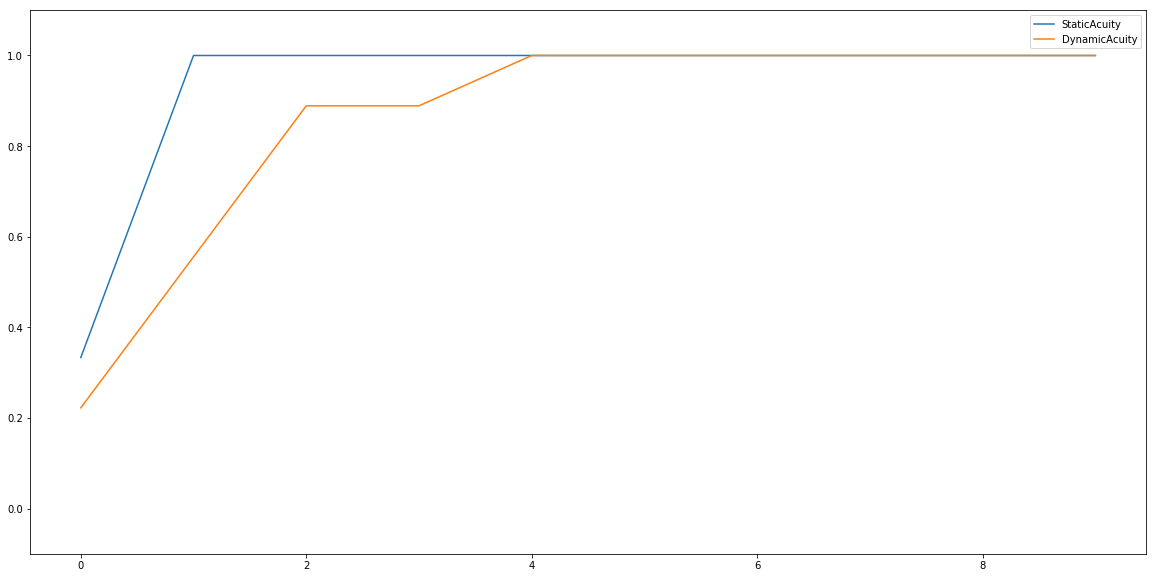

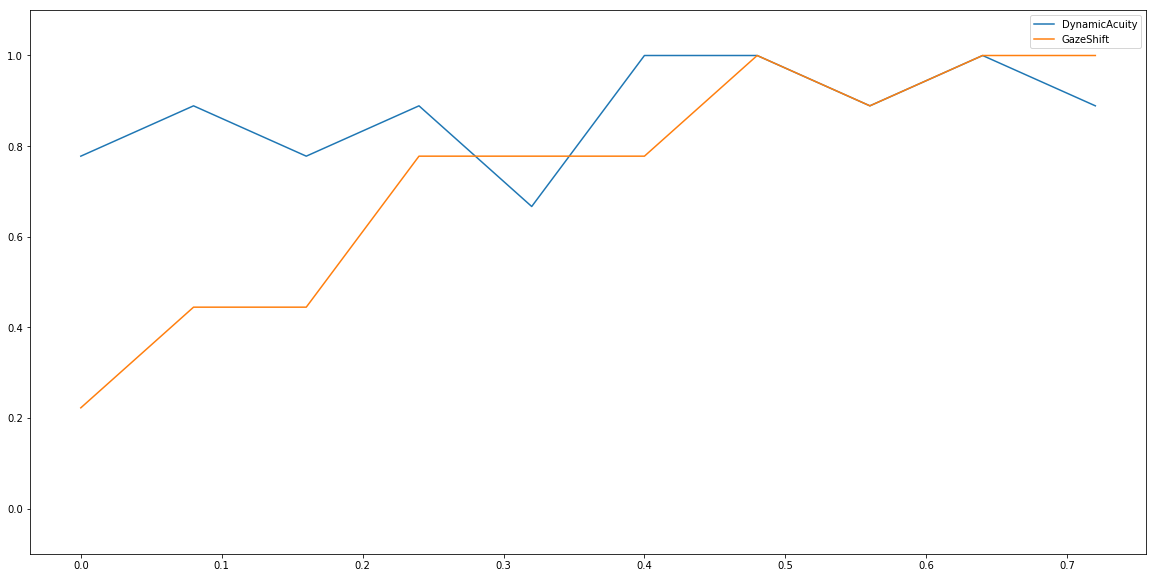

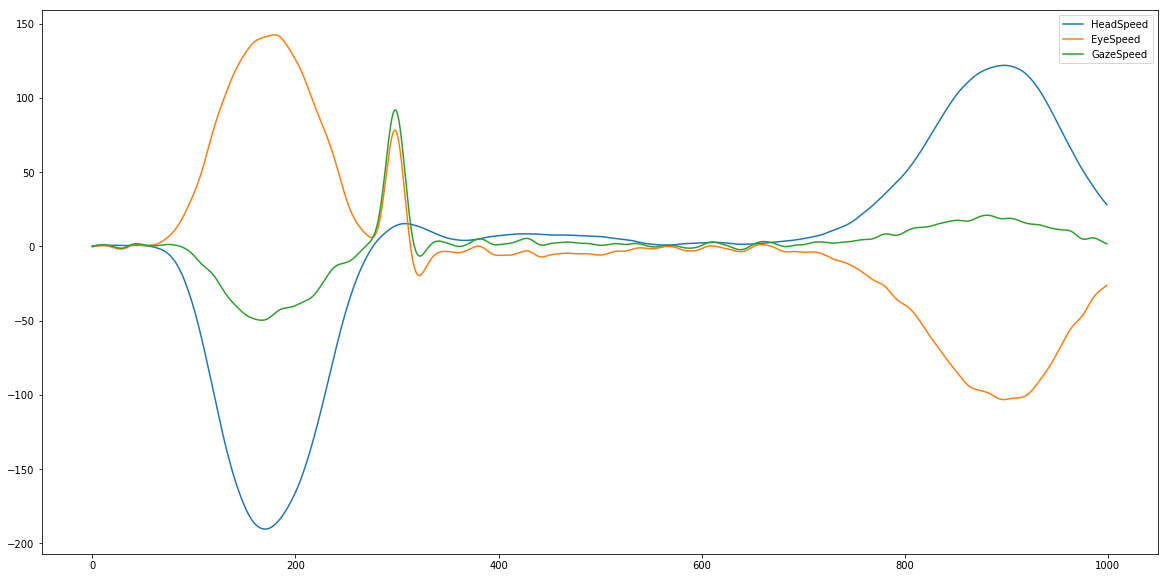

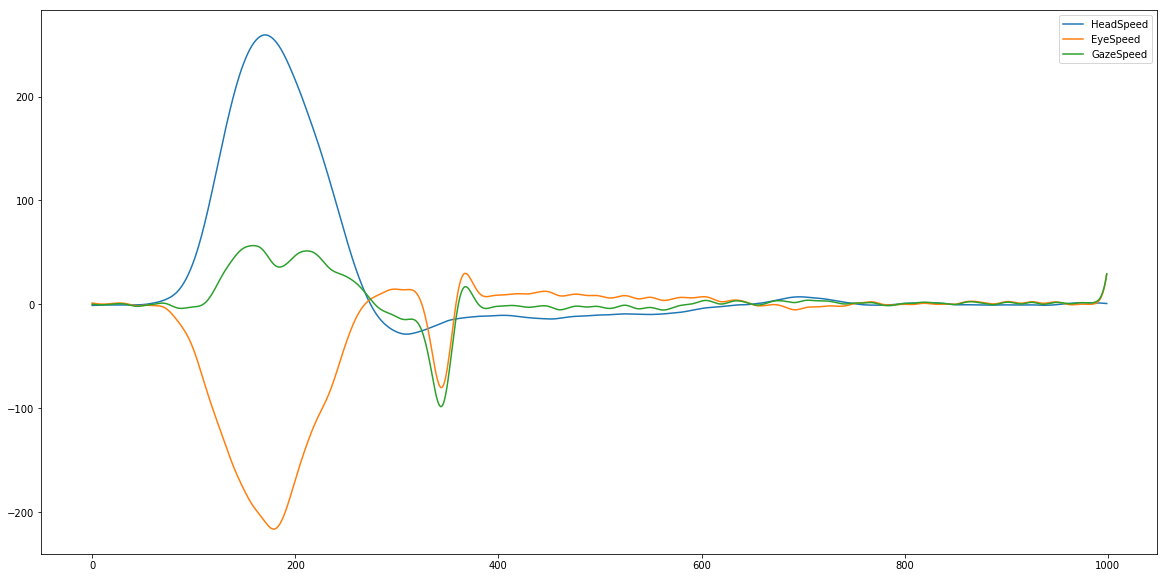

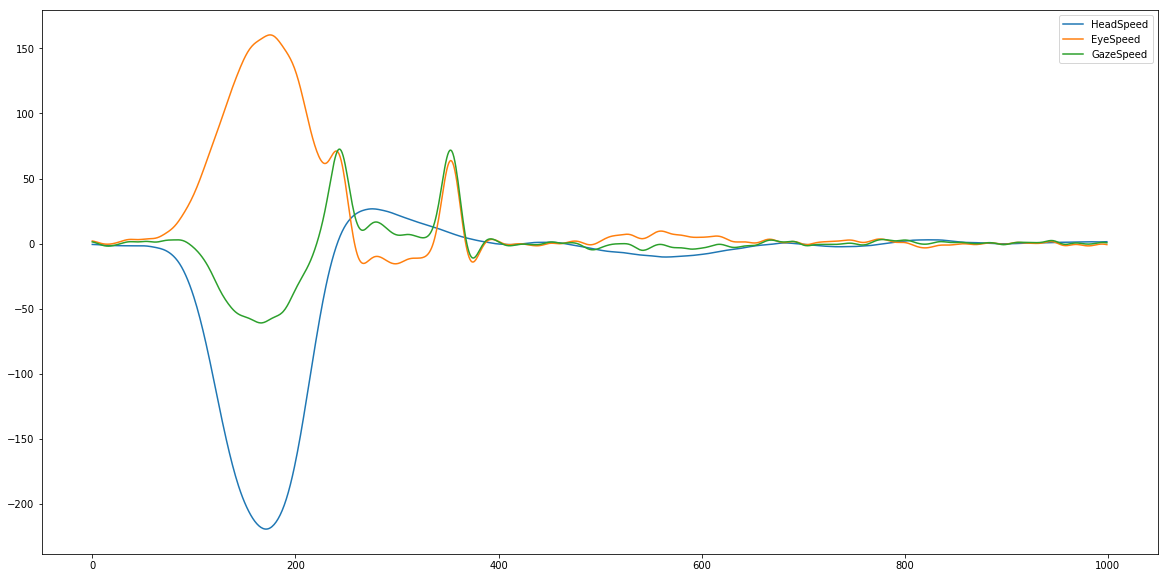

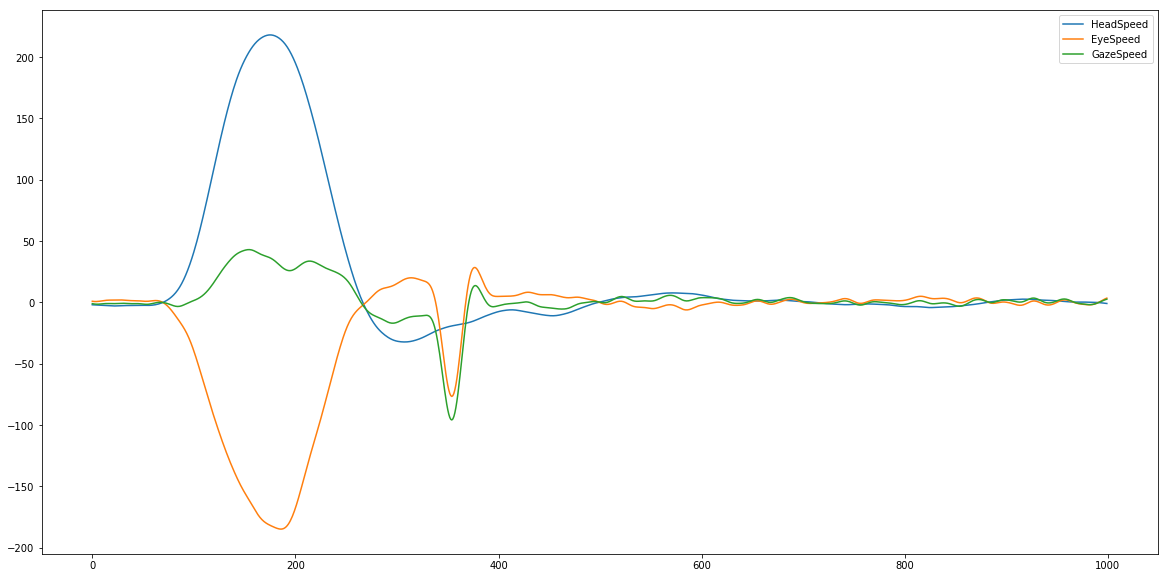

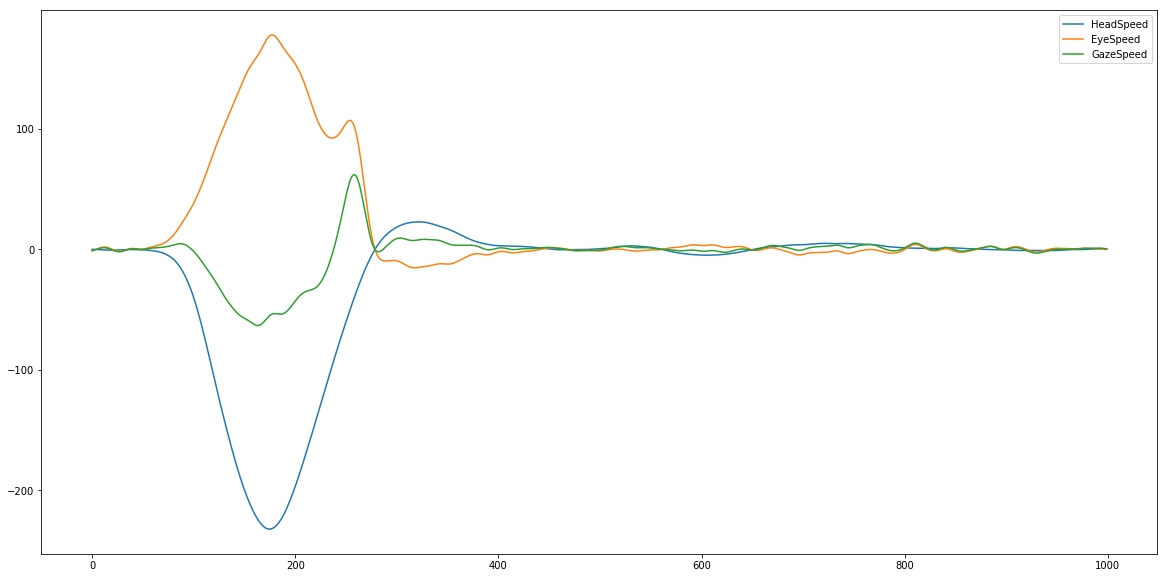

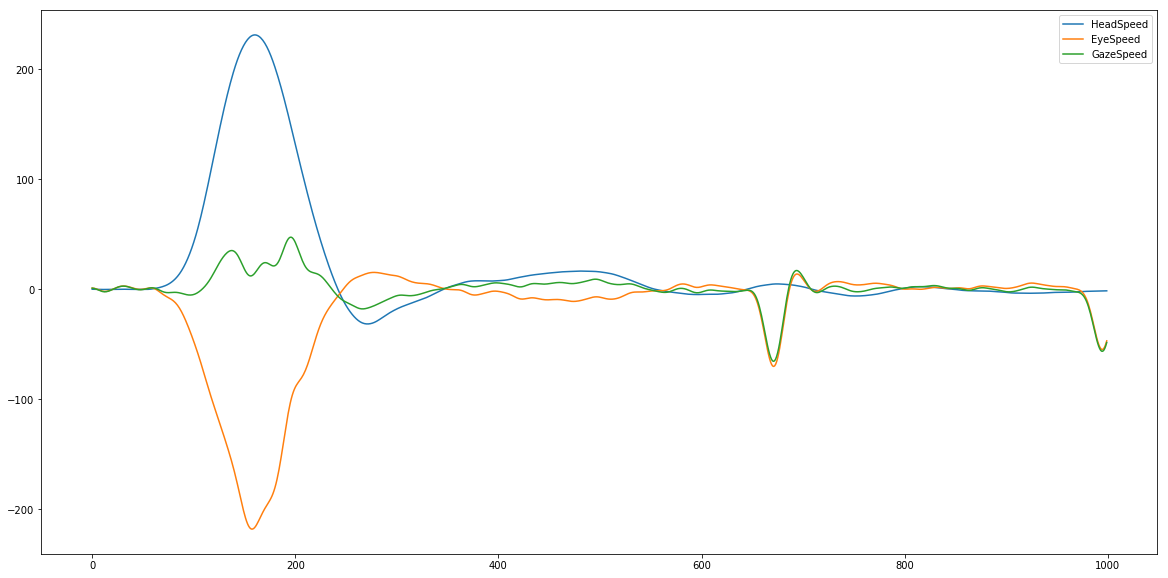

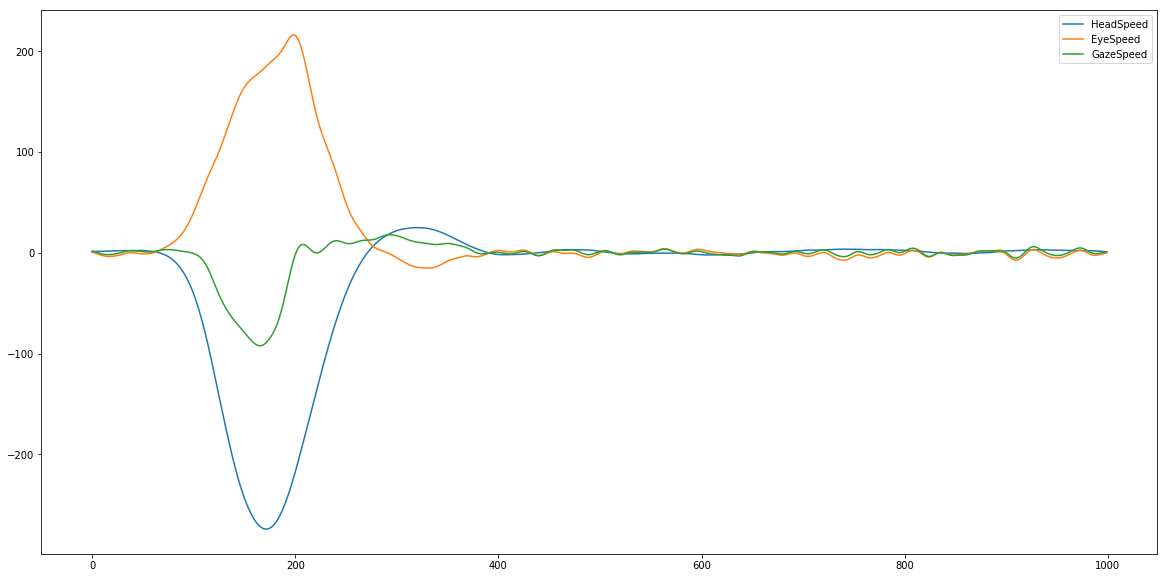

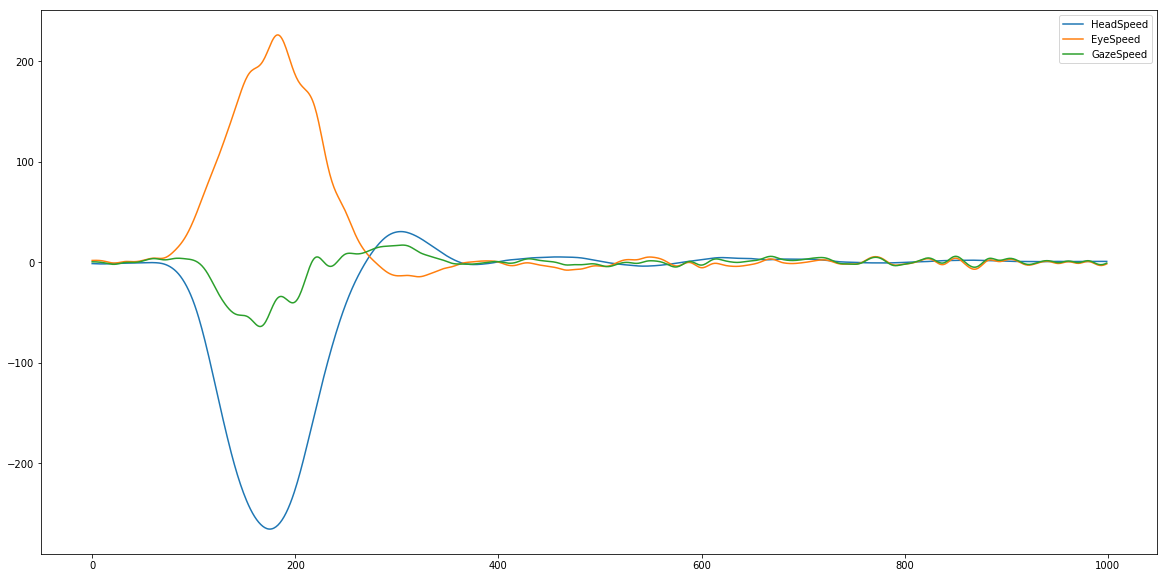

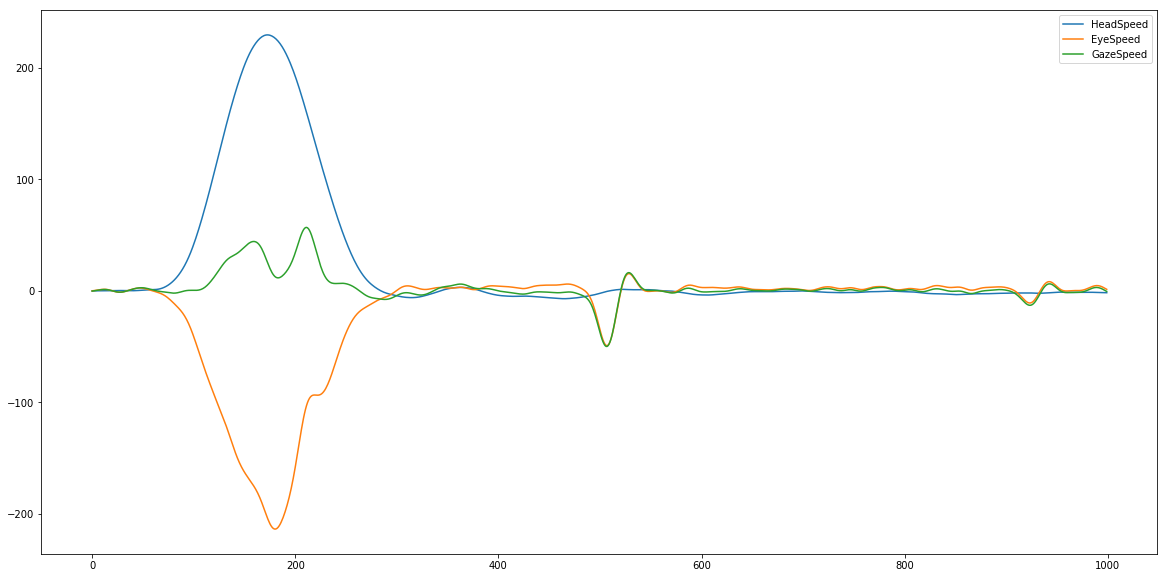

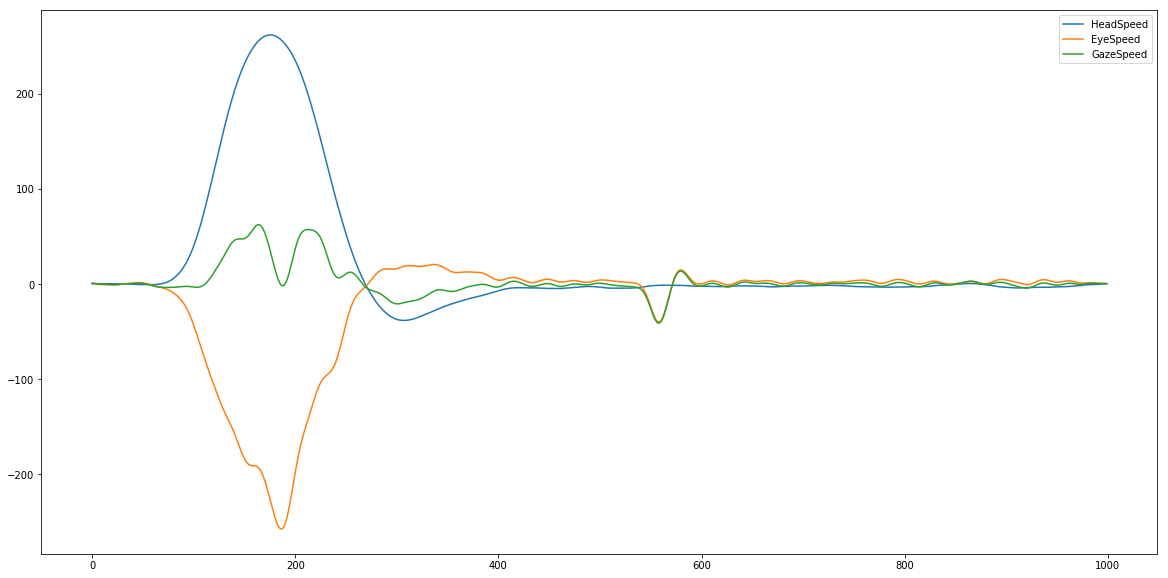

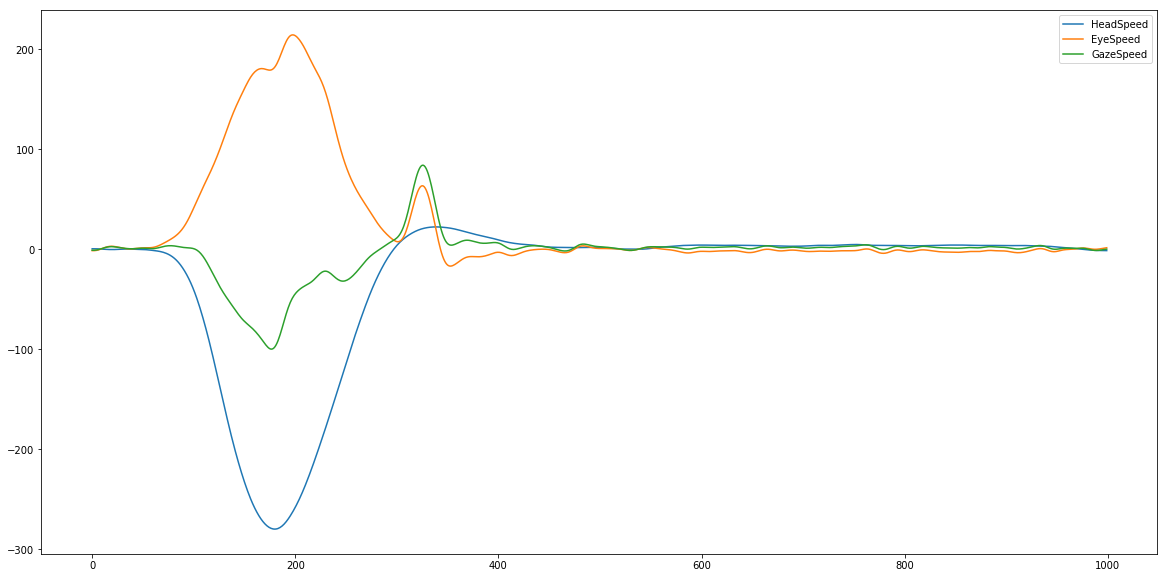

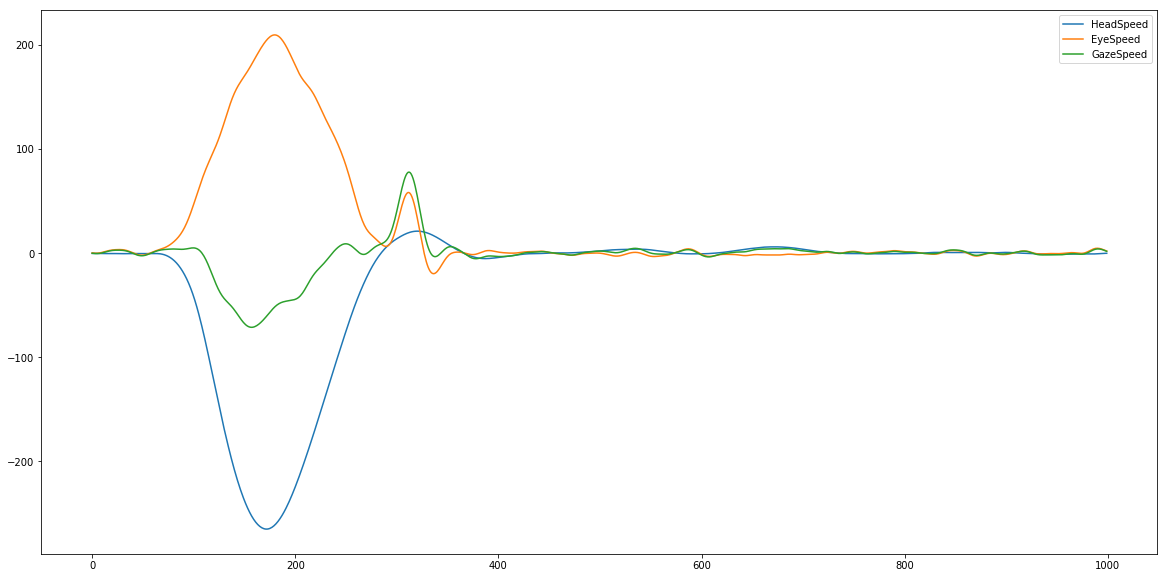

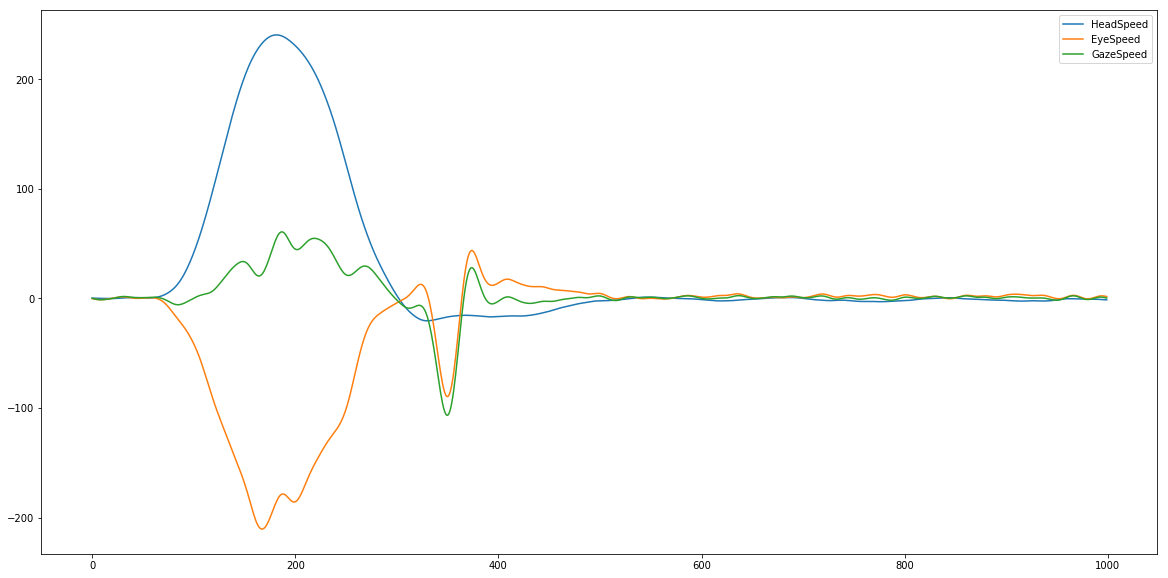

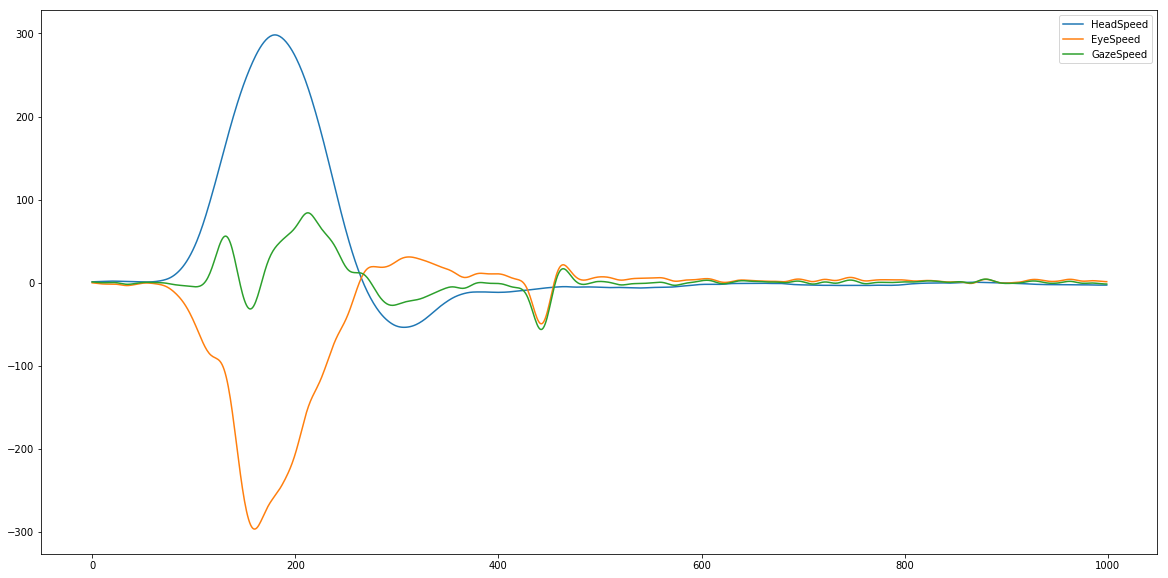

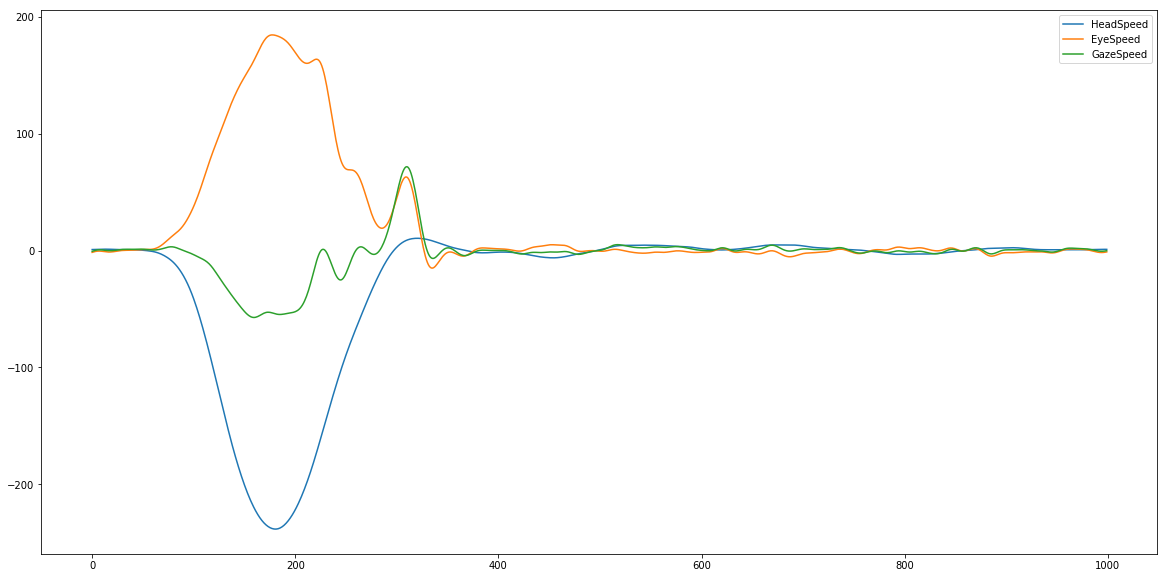

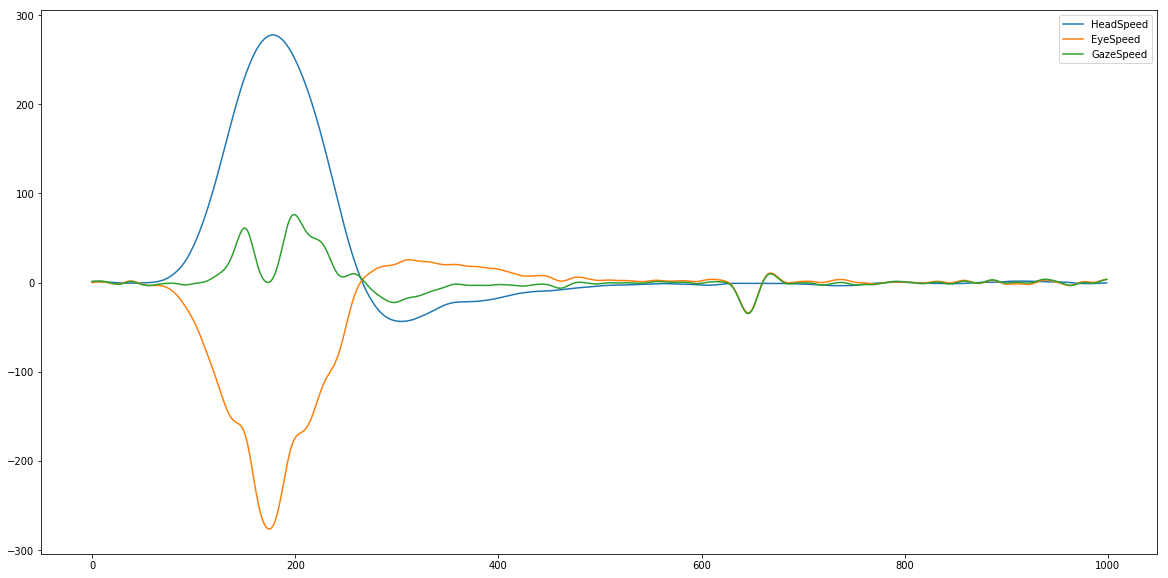

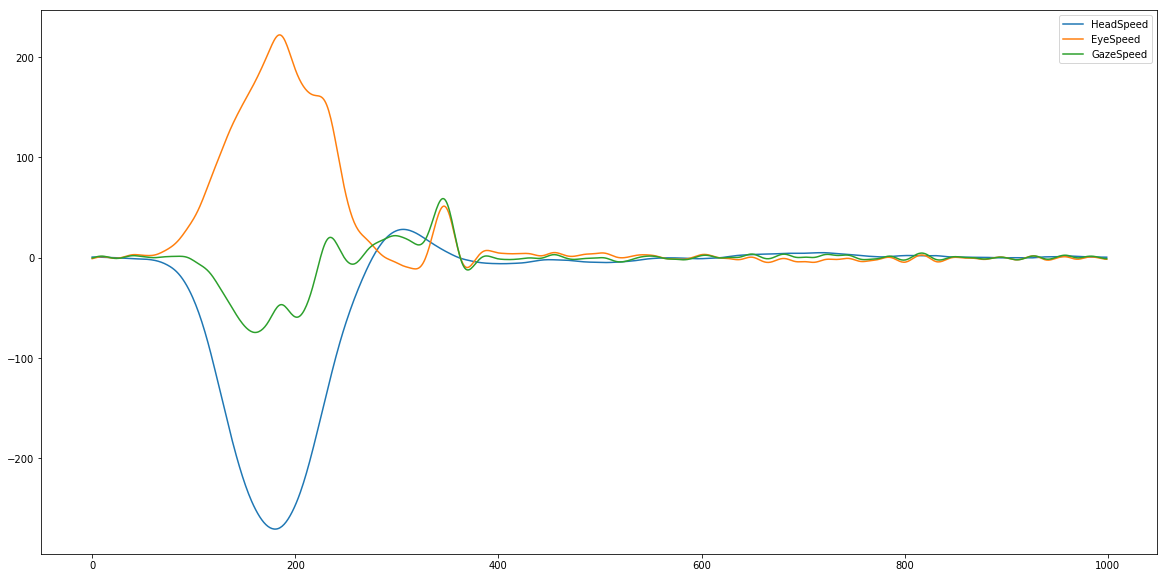

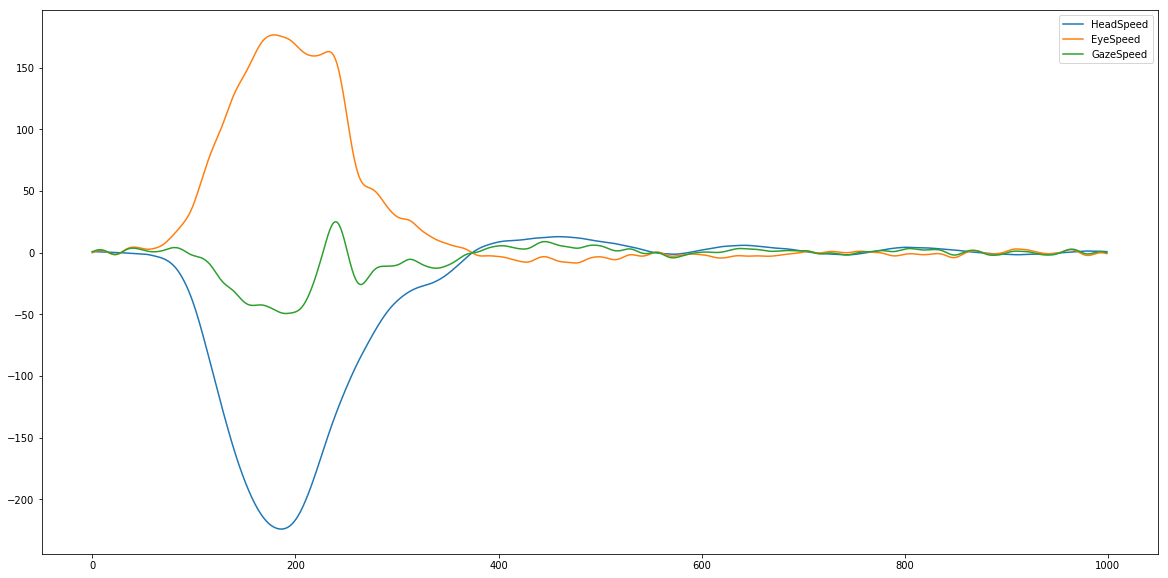

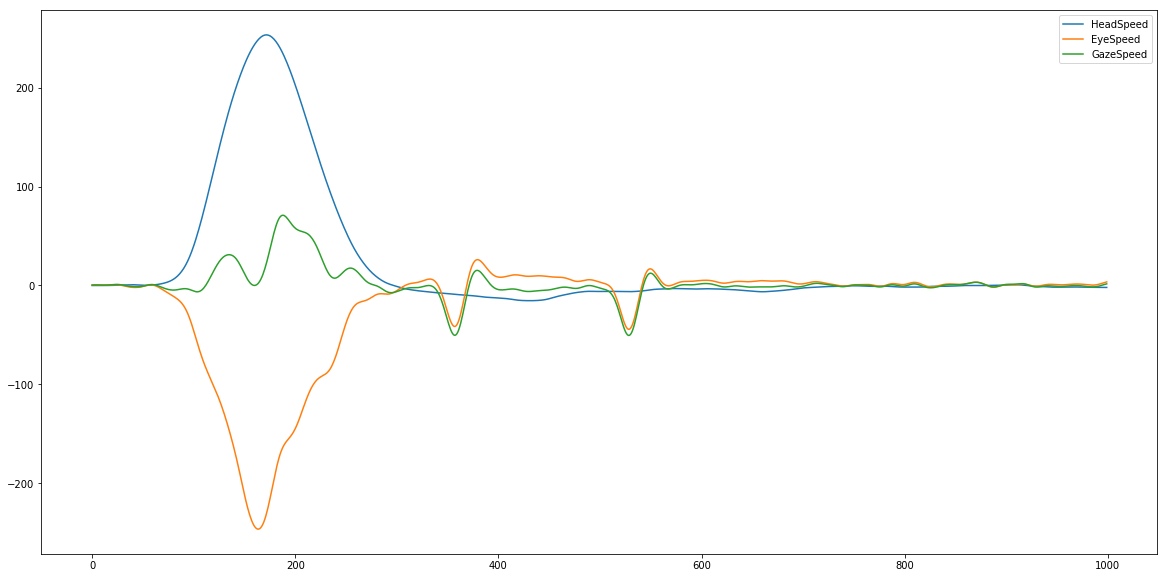

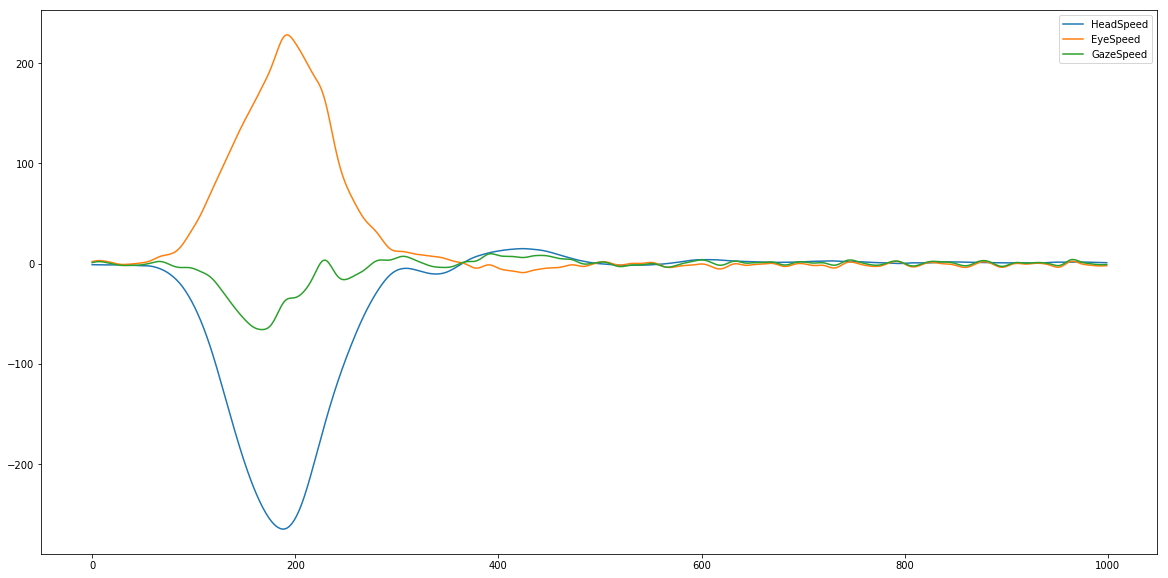

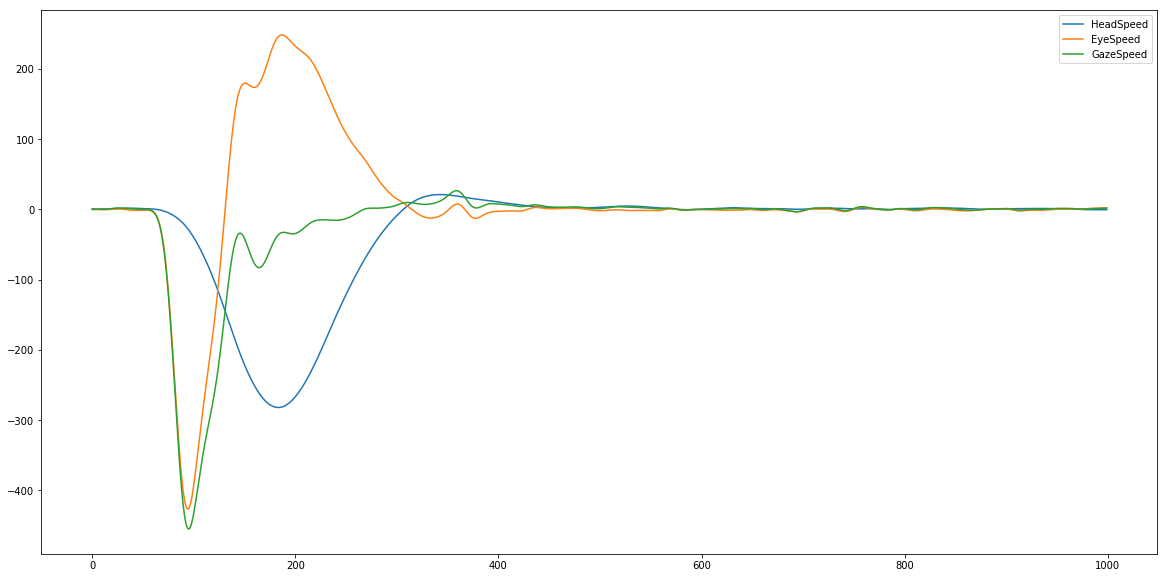

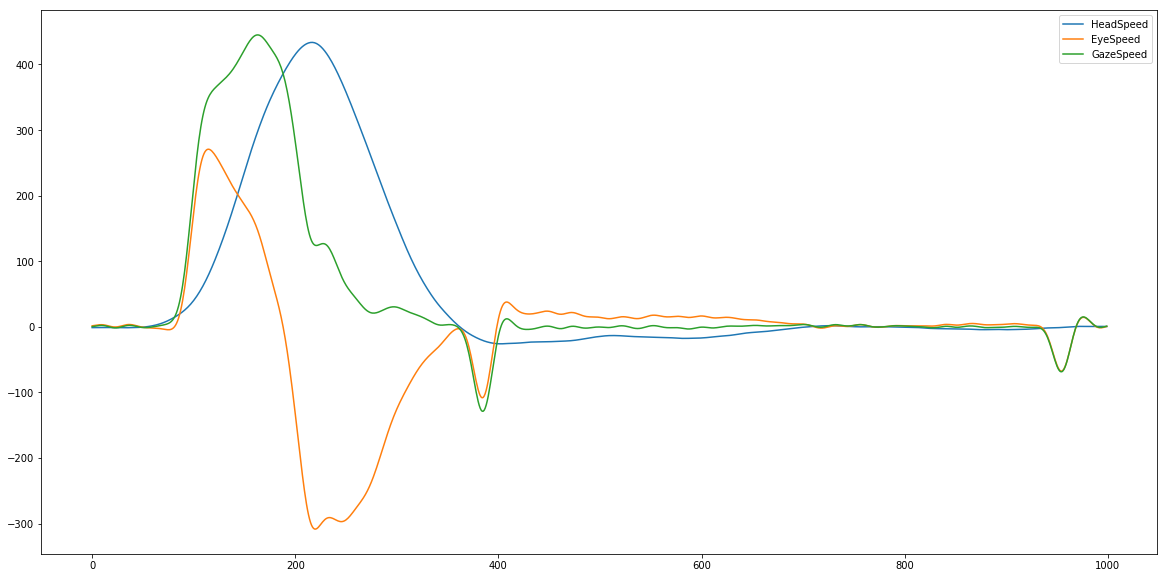

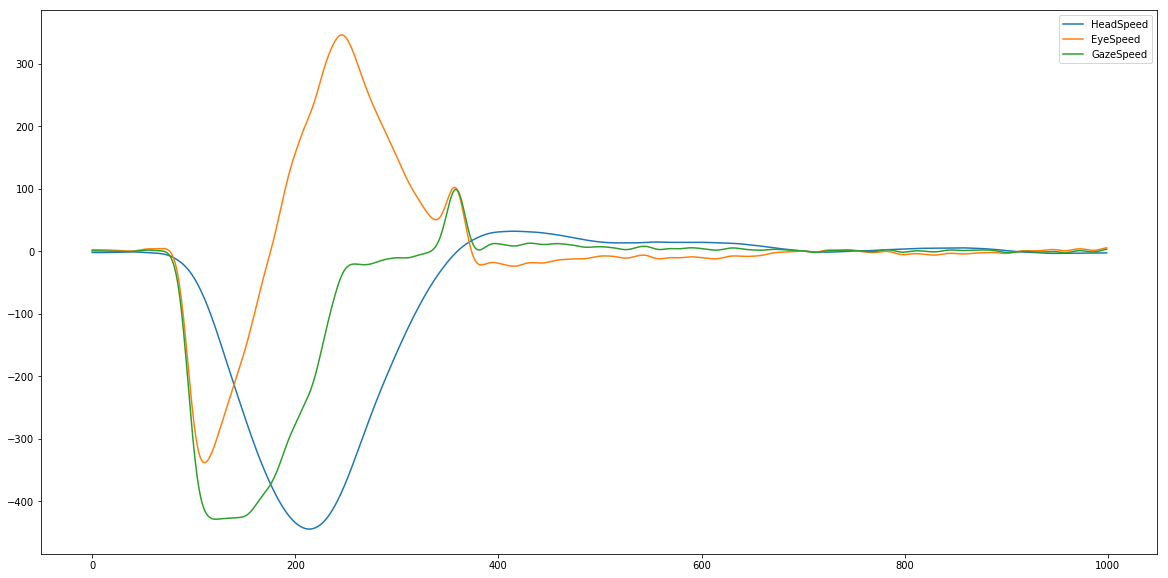

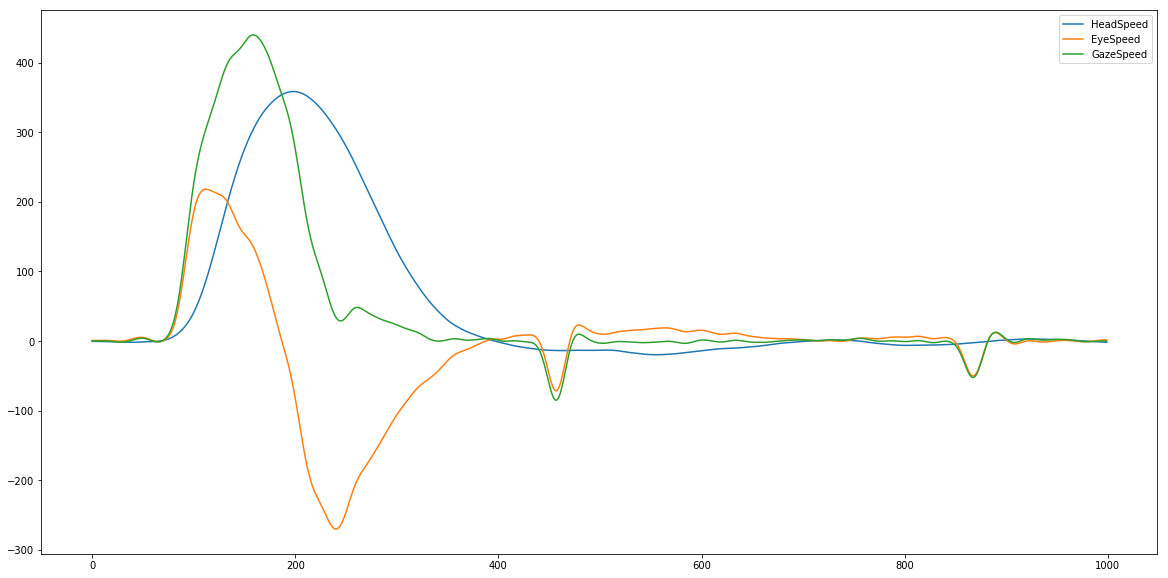

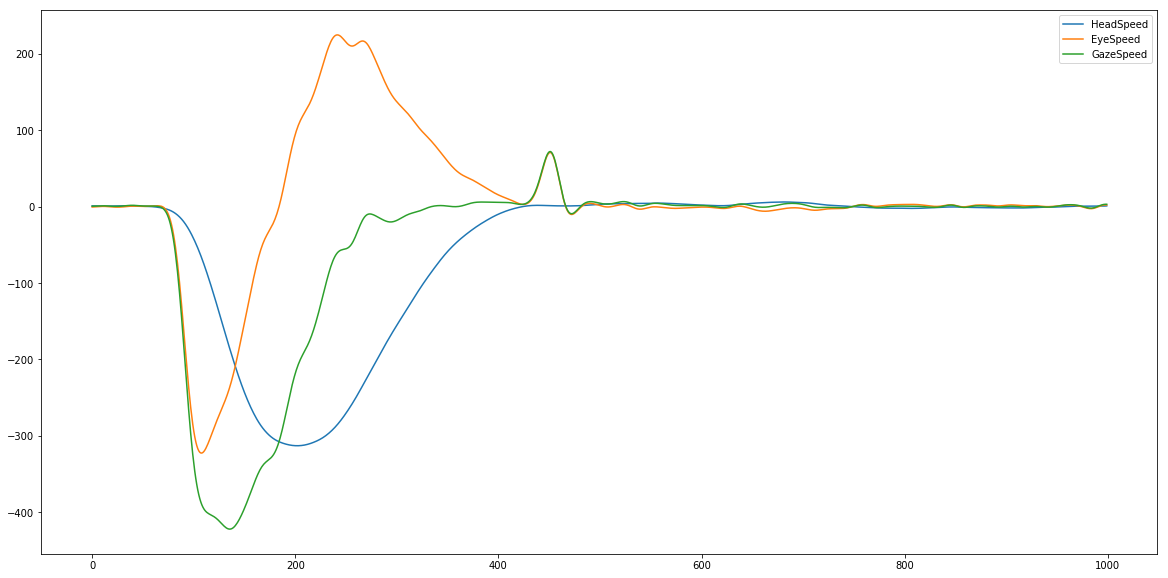

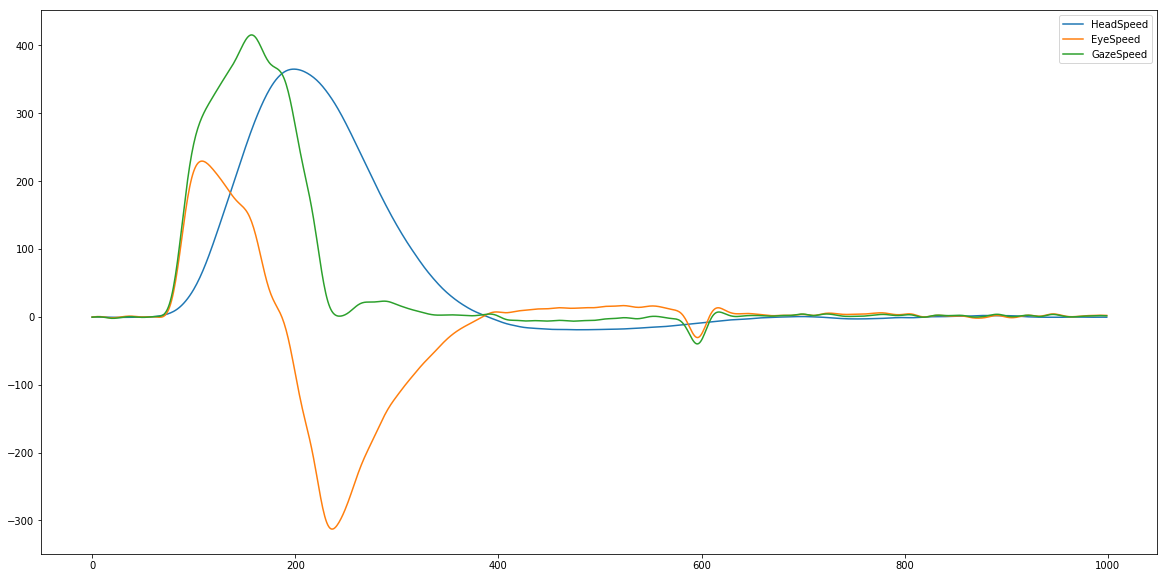

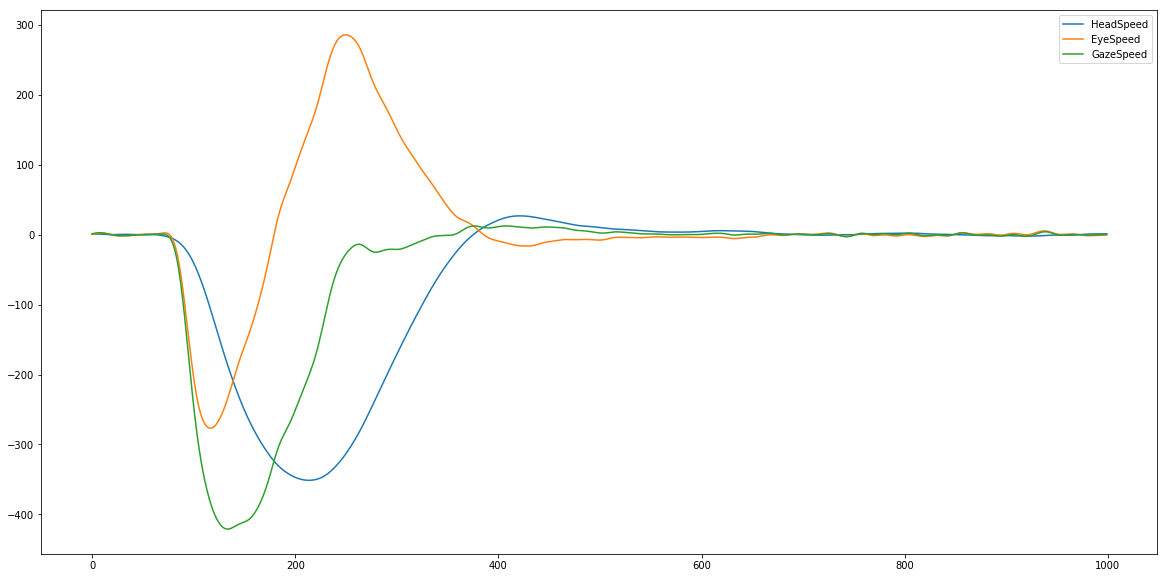

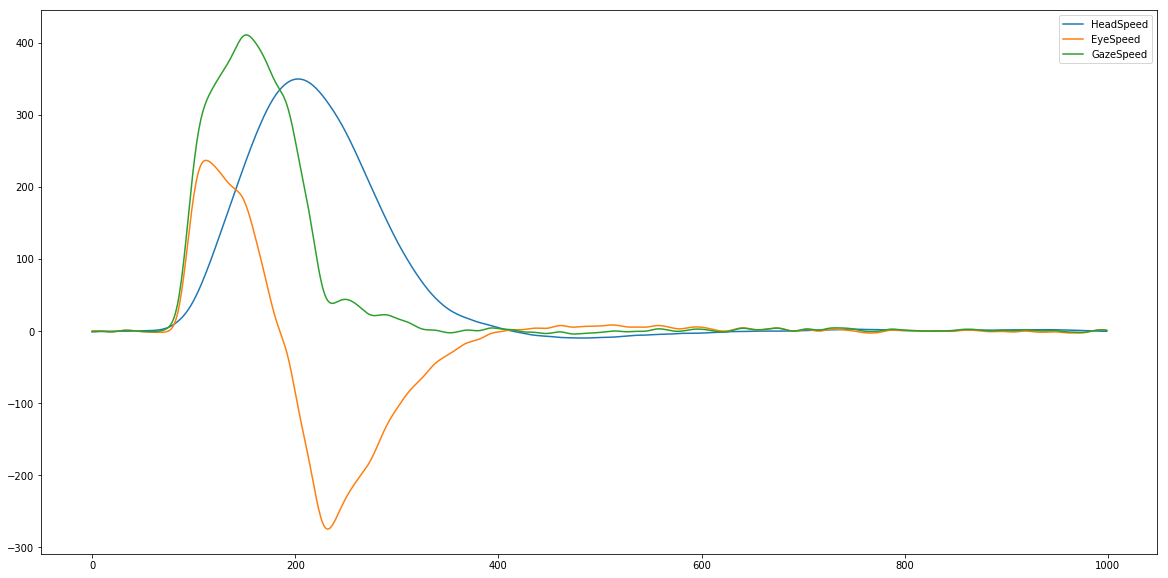

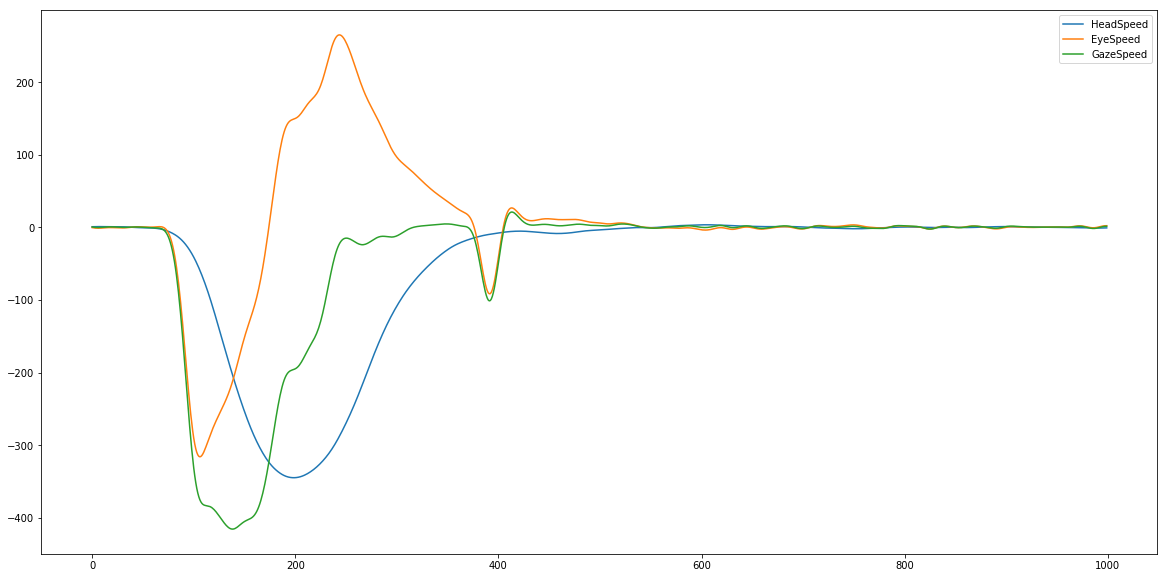

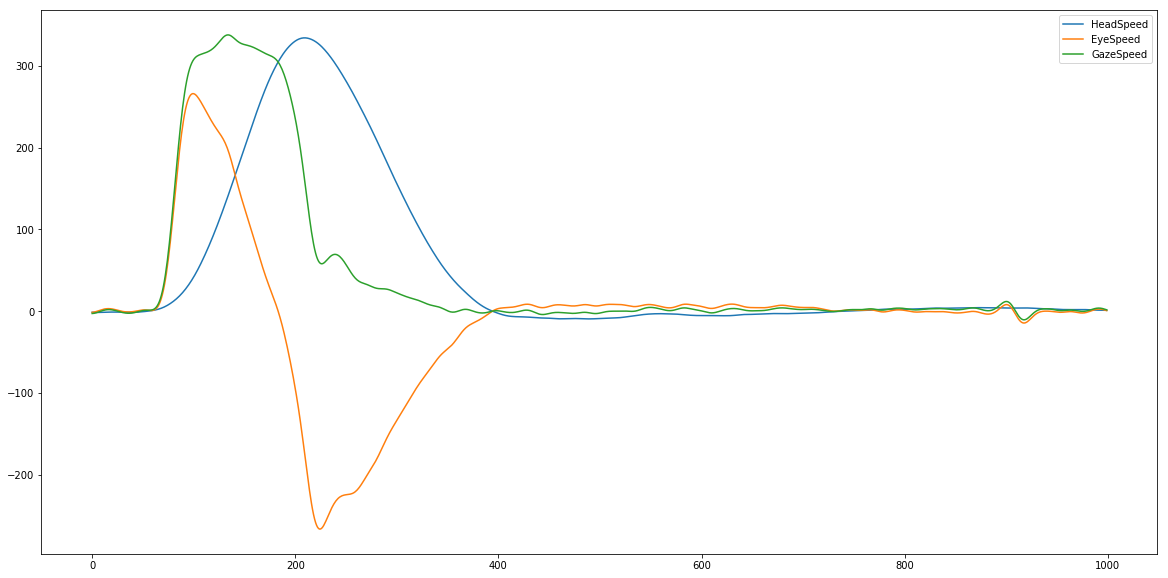

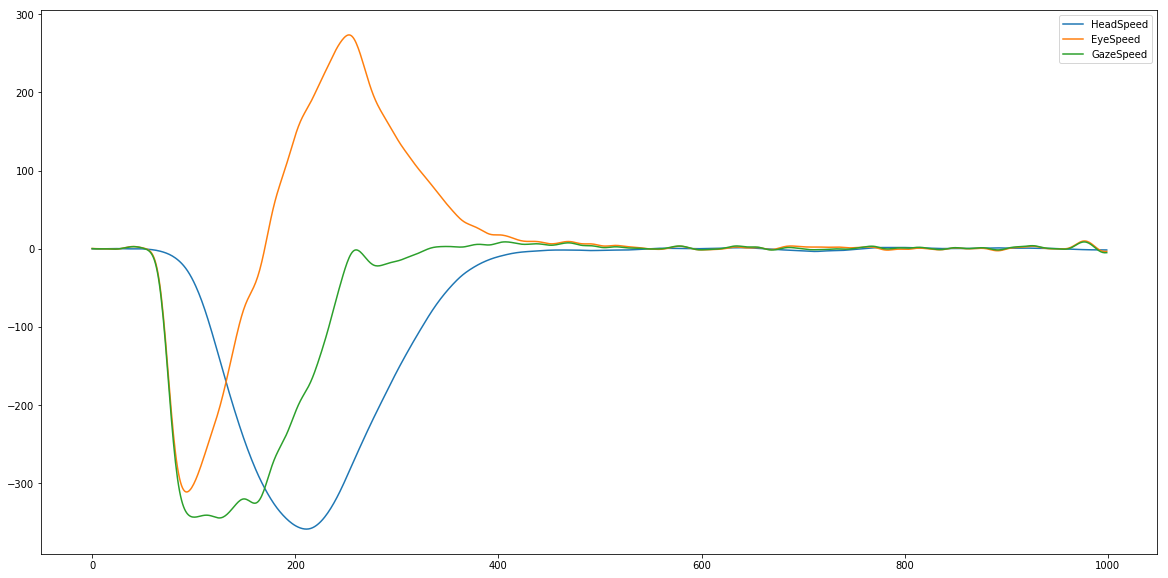

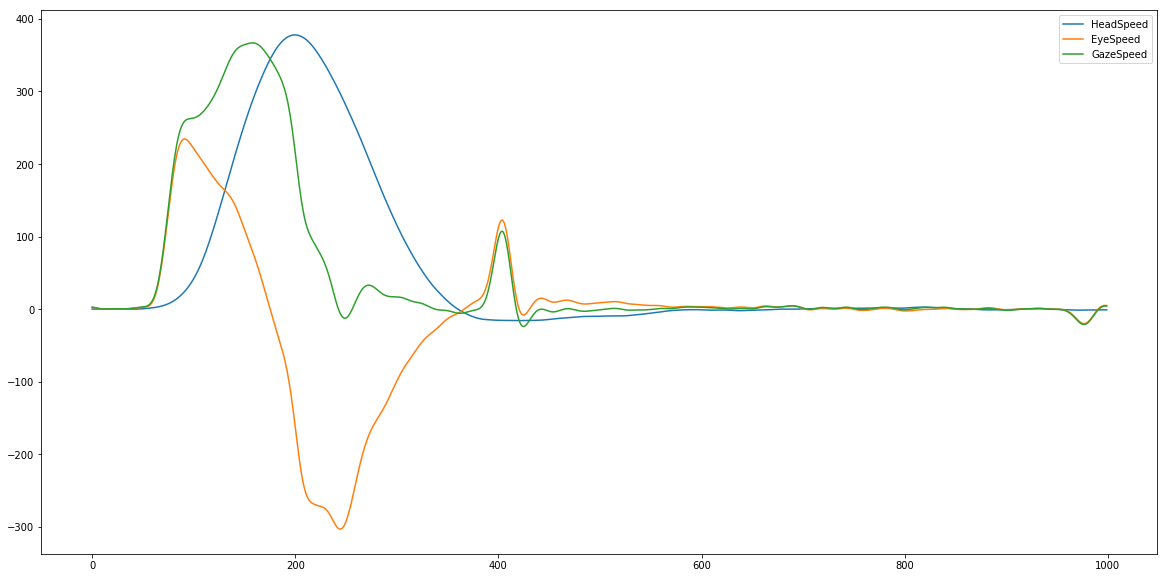

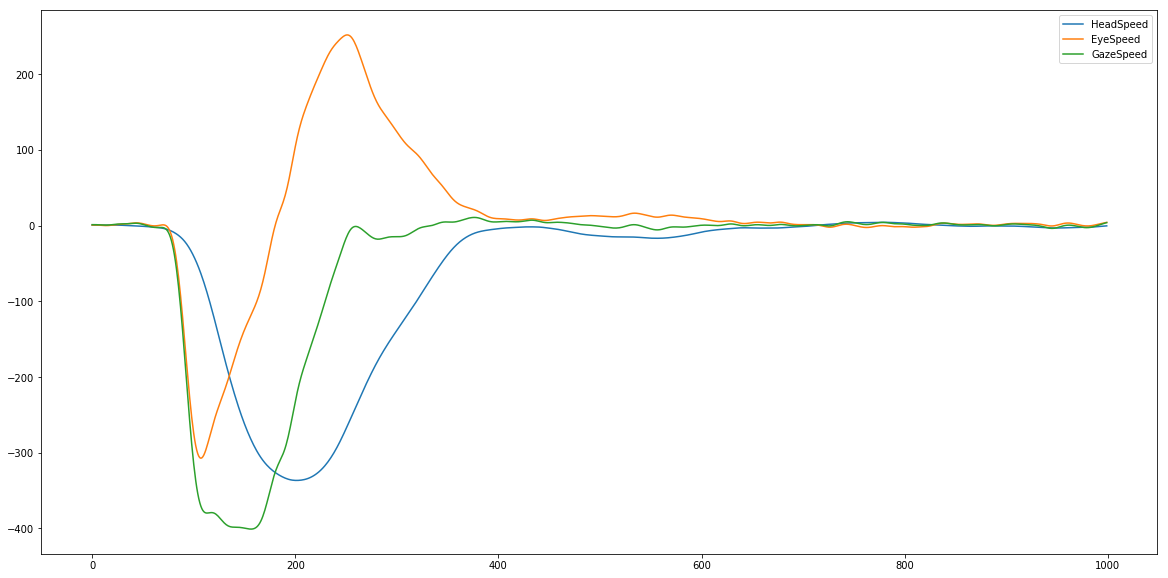

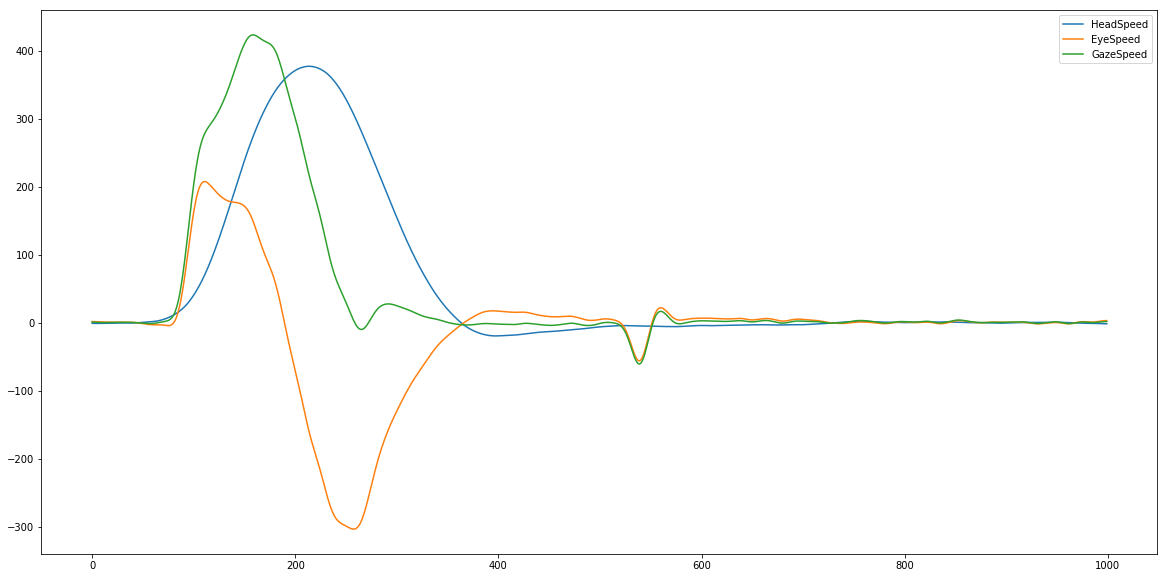

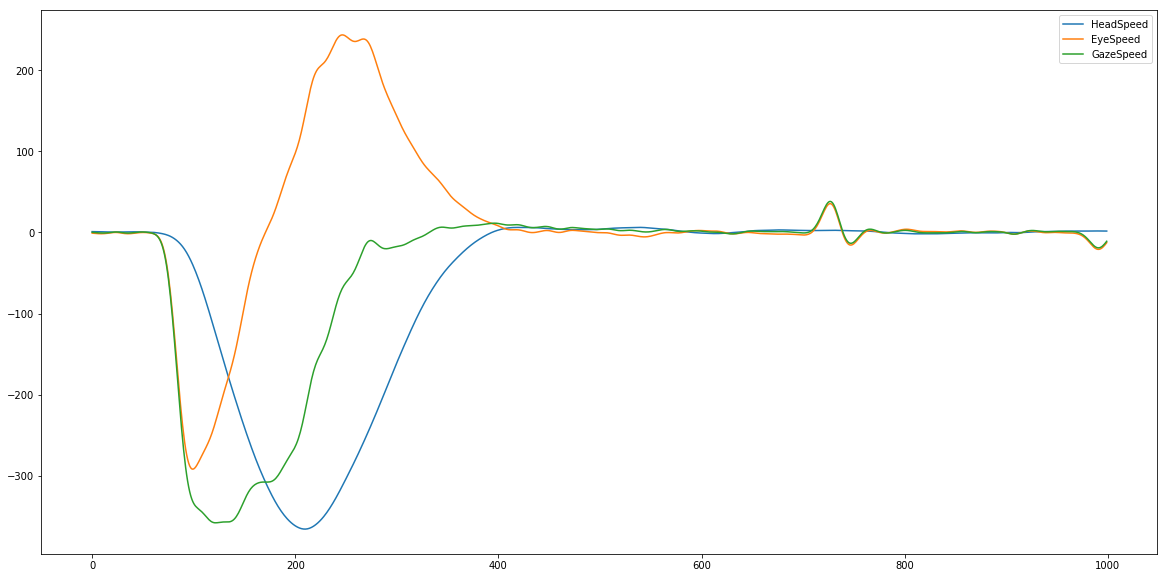

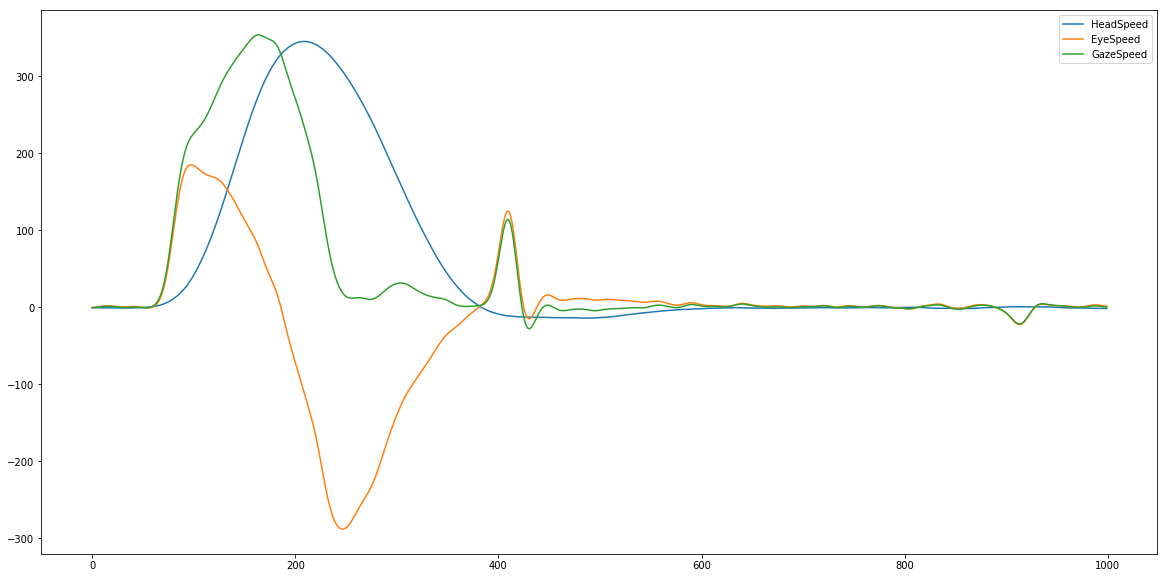

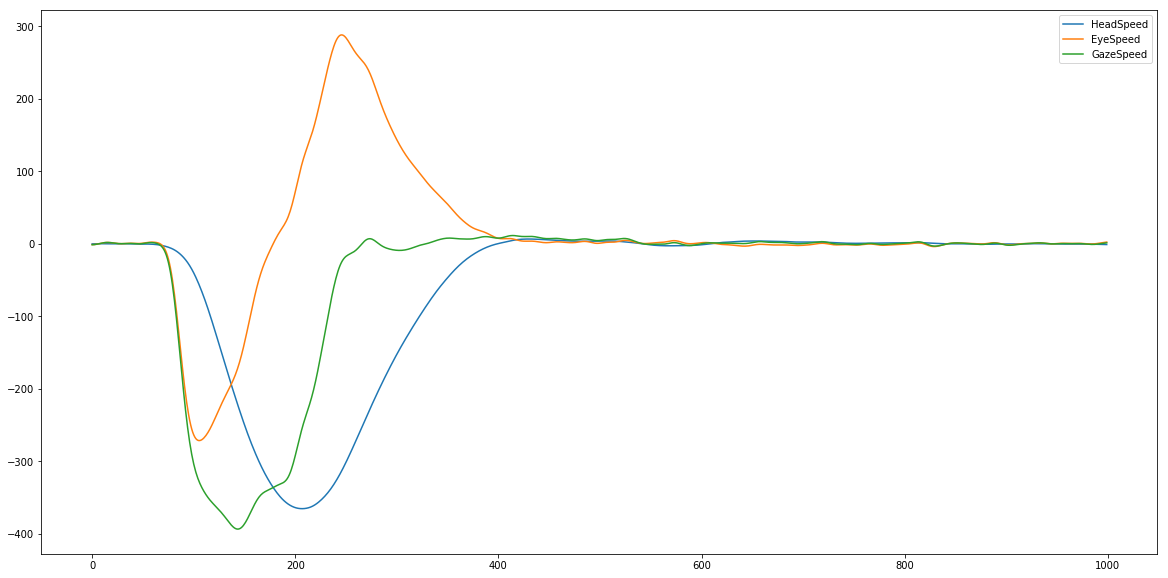

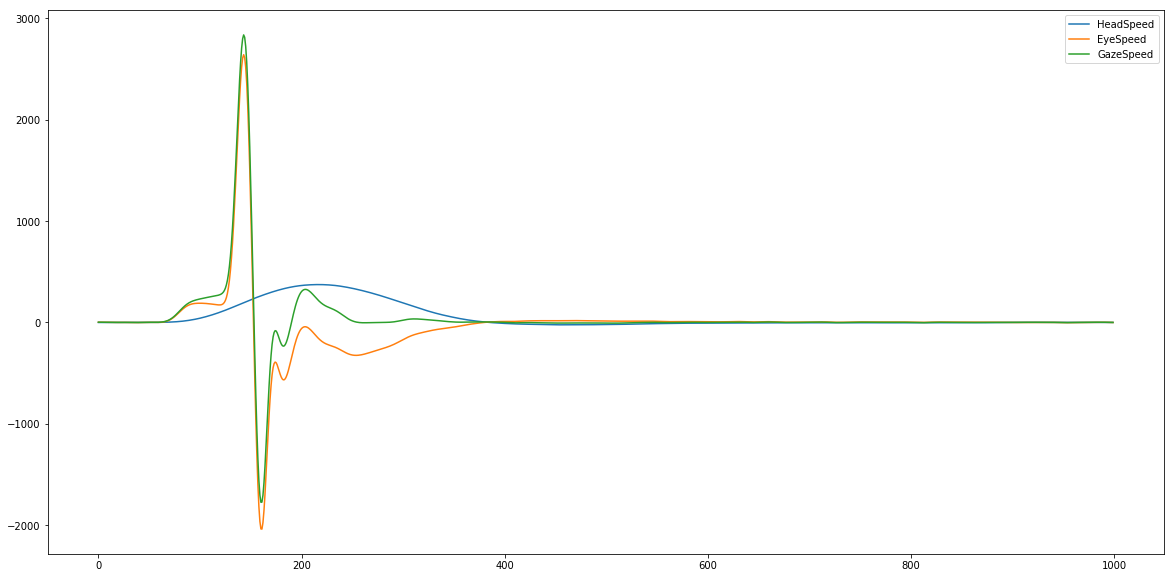

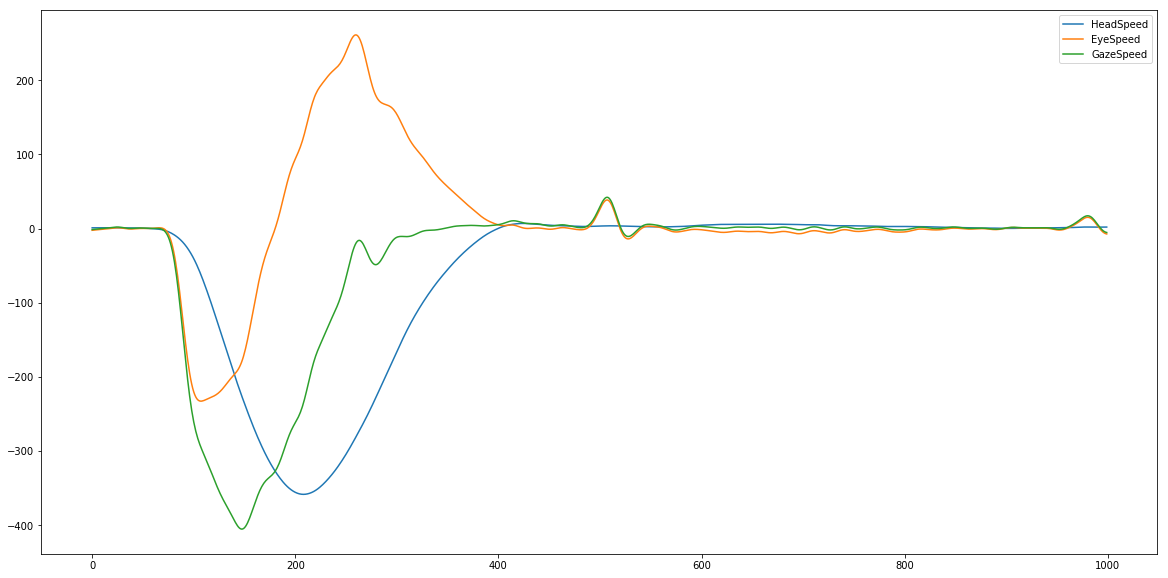

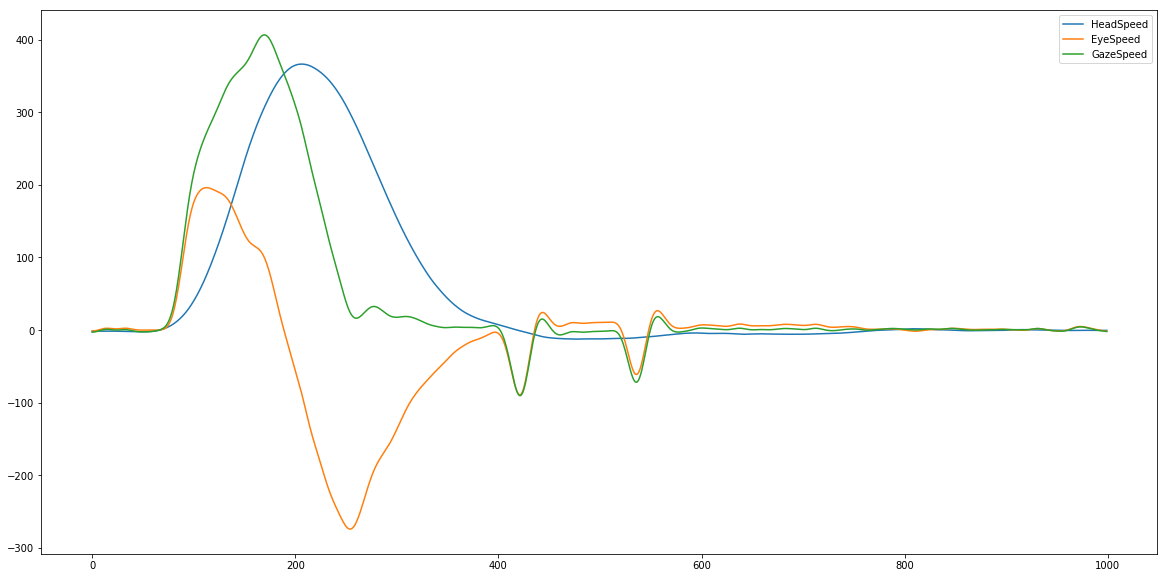

In [20]:
S_index += 1
sub1 = ["AcuityLog_2019_08_19_10_20_29.txt",\
        "AcuityLog_2019_08_19_10_35_08.txt",\
        "JumpLog__2019_08_19_10_20_29.txt",\
        "JumpLog__2019_08_19_10_35_08.txt",\
        "JumpLog__2019_08_19_10_35_08_2.txt",\
        "AcuityLog_2019_08_19_10_50_10.txt",\
        "",\
        "Mdata.mat",\
        "0"]
run_subject(sub1[0],sub1[1],sub1[2],sub1[3],sub1[4],sub1[5],sub1[6],sub1[7],int(sub1[8]))

In [18]:
S_index += 1
sub1 = ["AcuityLog_2019_08_30_01_05_31.txt","AcuityLog_2019_08_30_01_19_07.txt","JumpLog__2019_08_30_01_05_31.txt","JumpLog__2019_08_30_01_19_07.txt","JumpLog__2019_08_30_01_19_07_2.txt"]
run_subject(sub1[0],sub1[1],sub1[2],sub1[3],sub1[4])

TypeError: run_subject() missing 4 required positional arguments: 'EY_log', 'EY_JU_log', 'Mat_log', and 'eye_index'

In [ ]:
S_index += 1
sub1 = ["AcuityLog_2019_08_30_02_09_54.txt","AcuityLog_2019_08_30_02_25_56.txt","JumpLog__2019_08_30_02_09_54.txt","JumpLog__2019_08_30_02_25_56.txt","JumpLog__2019_08_30_02_25_56_2.txt"]
run_subject(sub1[0],sub1[1],sub1[2],sub1[3],sub1[4])

In [ ]:
S_index += 1
sub1 = ["AcuityLog_2019_08_30_03_30_50.txt","AcuityLog_2019_08_30_03_55_04.txt","JumpLog__2019_08_30_03_30_50.txt","JumpLog__2019_08_30_03_55_04.txt","JumpLog__2019_08_30_03_55_04_2.txt"]
run_subject(sub1[0],sub1[1],sub1[2],sub1[3],sub1[4])

In [ ]:
def mix_plot():
    handles = []
    for SS in StaticSections:
        tpl = plot_ac(SS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"StaticMix"+".png")
    pyplot.show()
    
    handles = []
    for DS in DynamicSections:
        tpl = plot_ac(DS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"DynamicMix"+".png")
    pyplot.show()
    
    handles = []
    for DDS in DY_delaySections:
        tpl = plot_delay(DDS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"DynamicDelayMix"+".png")
    pyplot.show()
    
    handles = []
    for GDS in GA_delaySections:
        tpl = plot_delay(GDS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"GazeDelayMix"+".png")
    pyplot.show()

In [ ]:
mix_plot()